In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import warnings
warnings.filterwarnings("ignore")

from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split

from imblearn.over_sampling import SMOTE

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
import tensorflow as tf

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from collections import Counter

# Exploring dataset and its dimensionality

In [ ]:
df = pd.read_csv("/content/lung_cancer_mortality_data_test_v2.csv")

In [ ]:
df.head()

,id,age,gender,country,diagnosis_date,cancer_stage,beginning_of_treatment_date,family_history,smoking_status,bmi,cholesterol_level,hypertension,asthma,cirrhosis,other_cancer,treatment_type,end_treatment_date,survived
0,1,64.0,Female,Slovakia,2016-04-07,Stage IV,2016-04-09,No,Former Smoker,21.2,191,0,0,0,0,Surgery,2017-02-10,0
1,2,50.0,Male,Slovenia,2023-04-22,Stage III,2023-05-05,Yes,Current Smoker,36.4,258,1,0,0,0,Chemotherapy,2024-08-23,0
2,3,65.0,Male,Italy,2023-04-07,Stage II,2023-04-12,Yes,Former Smoker,18.9,174,1,0,1,0,Chemotherapy,2025-03-24,1
3,4,51.0,Male,Latvia,2016-02-07,Stage I,2016-03-08,No,Passive Smoker,38.8,279,1,0,0,0,Combined,2017-03-01,0
4,5,37.0,Female,Spain,2023-12-01,Stage II,2023-12-04,Yes,Former Smoker,37.7,273,0,0,0,0,Combined,2025-07-16,0


In [ ]:
df.shape

(1000, 18)

# Looking out for NULL values

In [ ]:
df.isna().sum()

,0
id,0
age,0
gender,0
country,0
diagnosis_date,0
cancer_stage,0
beginning_of_treatment_date,0
family_history,0
smoking_status,0
bmi,0


In [ ]:
def datediff(x, y):
    date_x = datetime.strptime(x, "%Y-%m-%d")
    date_y = datetime.strptime(y, "%Y-%m-%d")
    diff = date_y - date_x

    return diff.days

# Calculating the total number of days for treatment despite the outcome

In [ ]:
df["days_of_treatment"] = 0

for i in range(df.shape[0]):
    df.iloc[i, -1] = datediff(df.iloc[i, 4], df.iloc[i, -3])

In [ ]:
df["diagnosis_treatment_start"] = 0

for i in range(df.shape[0]):
    df.iloc[i, -1] = datediff(df.iloc[i, 4], df.iloc[i, 6])

# Ratio of lethal and successful outcome

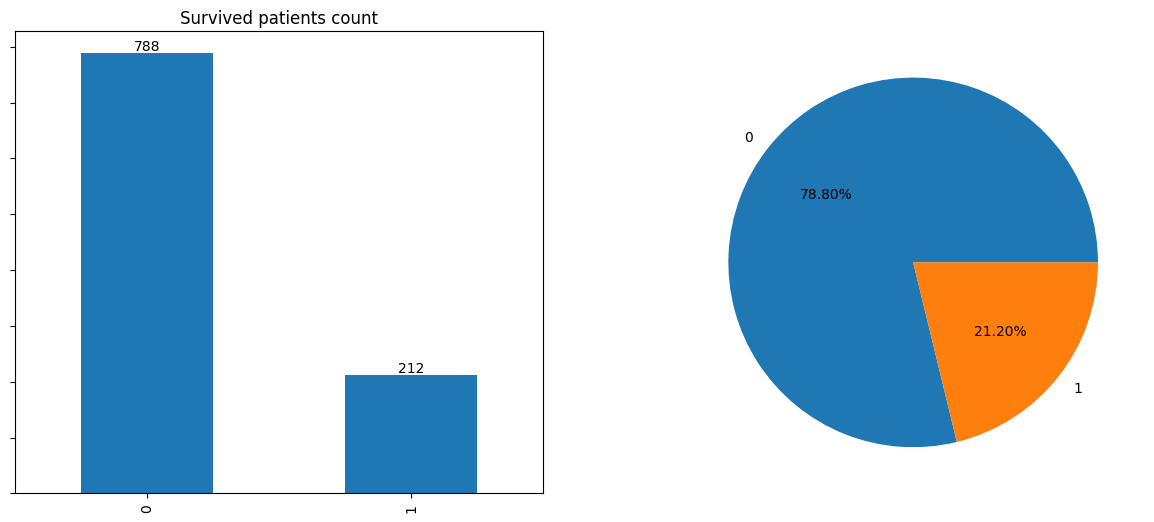

In [ ]:
count = df["survived"].value_counts()
fig, axes = plt.subplots(ncols=2, figsize=(15, 6))
count.plot(kind="bar", ax=axes[0])
for container in axes[0].containers:
    axes[0].bar_label(container)
axes[0].set_yticklabels(())
axes[0].set_ylabel("")
axes[0].set_xlabel("")
axes[0].set_title("Survived patients count")
count.plot(kind="pie", ax=axes[1], autopct="%0.2f%%")
axes[1].set_ylabel("")
plt.show()

# Average time to start treatment

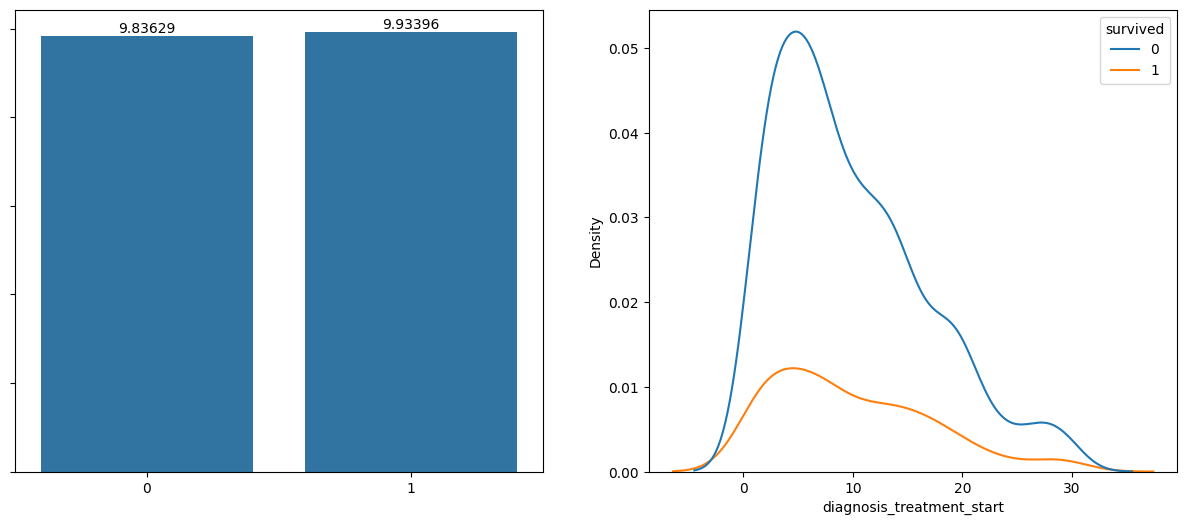

In [ ]:
grouped = df.groupby("survived")
mean = grouped["diagnosis_treatment_start"].mean()
fig, axes = plt.subplots(ncols=2, figsize=(15, 6))
sns.barplot(x=mean.index, y=mean, ax=axes[0])
for container in axes[0].containers:
    axes[0].bar_label(container)
axes[0].set_yticklabels(())
axes[0].set_ylabel("")
axes[0].set_xlabel("")

sns.kdeplot(df, x="diagnosis_treatment_start", hue="survived", ax=axes[1])

plt.show()

# Top countries with highest average time to start treatment and lowest average time to start treatment

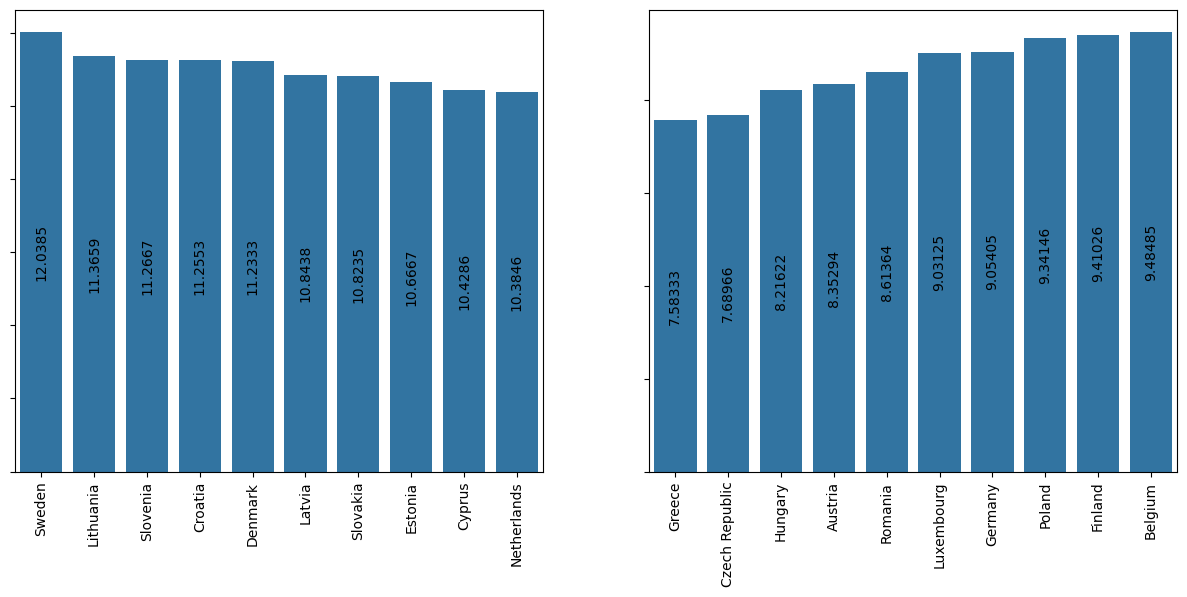

In [ ]:
grouped = df.groupby("country")
mean = pd.DataFrame(grouped["diagnosis_treatment_start"].mean())
mean = mean.sort_values("diagnosis_treatment_start", ascending=False)
fig, axes = plt.subplots(ncols=2, figsize=(15, 6))
sns.barplot(x=mean.index[:10], y=mean.iloc[:10, 0], ax=axes[0])
for container in axes[0].containers:
    axes[0].bar_label(container, rotation=90, label_type="center")
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=90)
axes[0].set_yticklabels(())
axes[0].set_ylabel("")
axes[0].set_xlabel("")

mean = mean.sort_values("diagnosis_treatment_start", ascending=True)
sns.barplot(x=mean.index[:10], y=mean.iloc[:10, 0], ax=axes[1])
for container in axes[1].containers:
    axes[1].bar_label(container, rotation=90, label_type="center")
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=90)
axes[1].set_yticklabels(())
axes[1].set_ylabel("")
axes[1].set_xlabel("")


plt.show()

# Average time of treatment in days and days distribution for each outcome

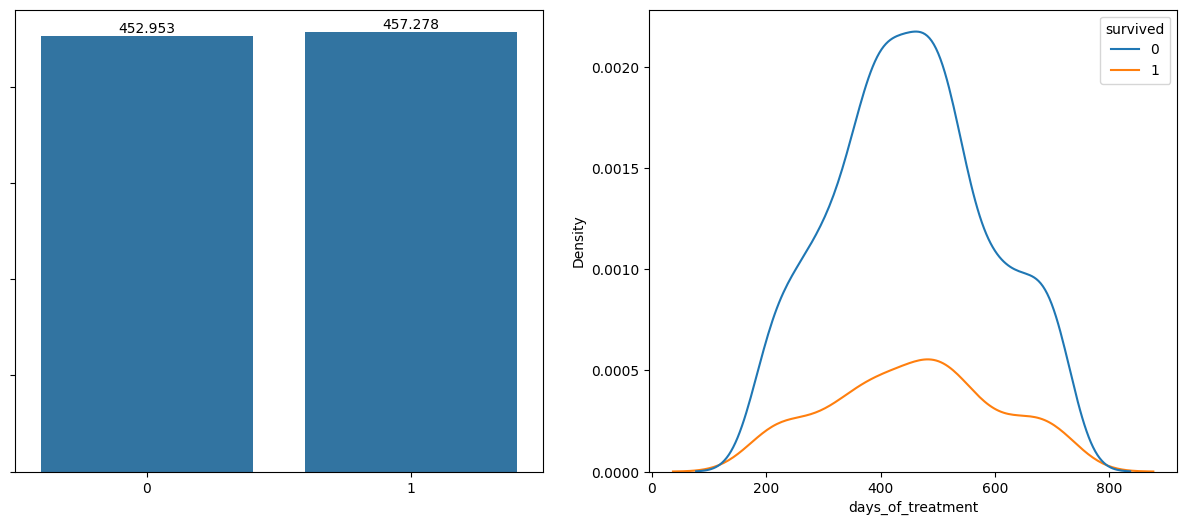

In [ ]:
grouped = df.groupby("survived")
mean = grouped["days_of_treatment"].mean()
fig, axes = plt.subplots(ncols=2, figsize=(15, 6))
sns.barplot(x=mean.index, y=mean, ax=axes[0])
for container in axes[0].containers:
    axes[0].bar_label(container)
axes[0].set_yticklabels(())
axes[0].set_ylabel("")
axes[0].set_xlabel("")

sns.kdeplot(df, x="days_of_treatment", hue="survived", ax=axes[1])

plt.show()

# Average age for both outcomes and age distribution through density curve

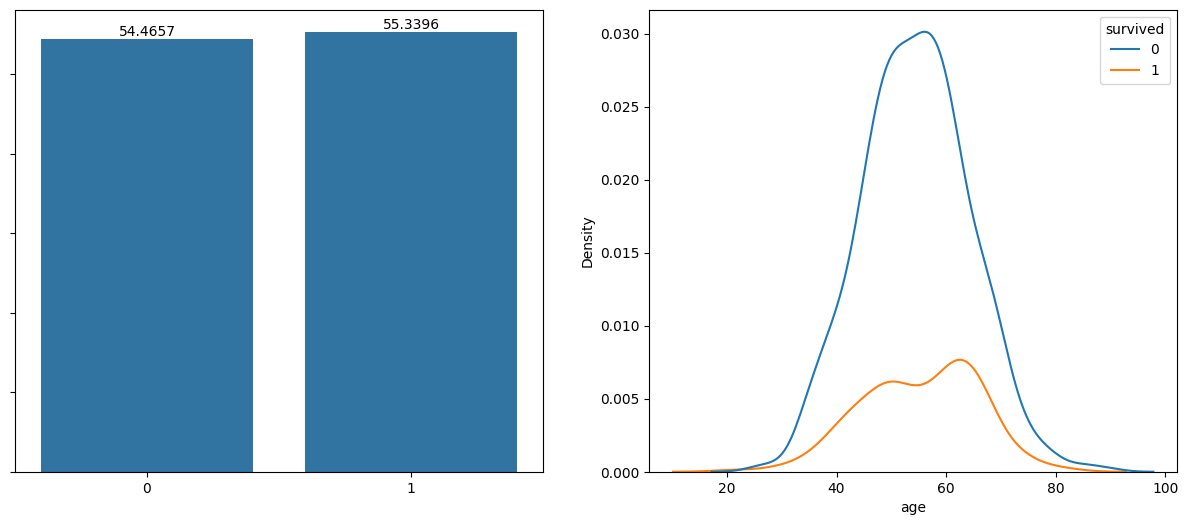

In [ ]:
grouped = df.groupby("survived")
mean = grouped["age"].mean()
fig, axes = plt.subplots(ncols=2, figsize=(15, 6))
sns.barplot(x=mean.index, y=mean, ax=axes[0])
for container in axes[0].containers:
    axes[0].bar_label(container)
axes[0].set_yticklabels(())
axes[0].set_ylabel("")
axes[0].set_xlabel("")

sns.kdeplot(df, x="age", hue="survived", ax=axes[1])

plt.show()

In [ ]:
survived_df = df[df["survived"] == 1].copy()
dead_df = df[df["survived"] == 0].copy()

# Countires count for each outcome

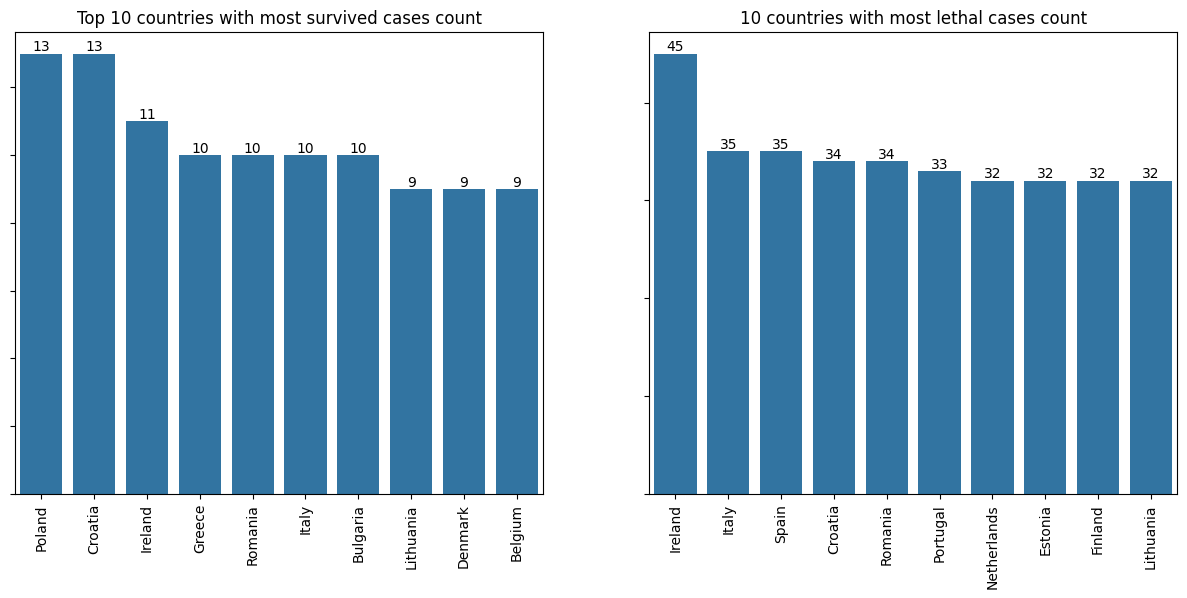

In [ ]:
survived_count = pd.DataFrame(survived_df["country"].value_counts()).sort_values("count", ascending=False)
dead_count = pd.DataFrame(dead_df["country"].value_counts()).sort_values("count", ascending=False)

fig, axes = plt.subplots(ncols=2, figsize=(15, 6))

sns.barplot(x=survived_count.index[:10], y=survived_count.iloc[:10, 0], ax=axes[0])
for container in axes[0].containers:
    axes[0].bar_label(container)
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=90)
axes[0].set_yticklabels(())
axes[0].set_ylabel("")
axes[0].set_xlabel("")
axes[0].set_title("Top 10 countries with most survived cases count")
sns.barplot(x=dead_count.index[:10], y=dead_count.iloc[:10, 0], ax=axes[1])

for container in axes[1].containers:
    axes[1].bar_label(container)
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=90)
axes[1].set_yticklabels(())
axes[1].set_ylabel("")
axes[1].set_xlabel("")
axes[1].set_title("10 countries with most lethal cases count")

plt.show()

# Countries count with highest number of the following smoking statuses

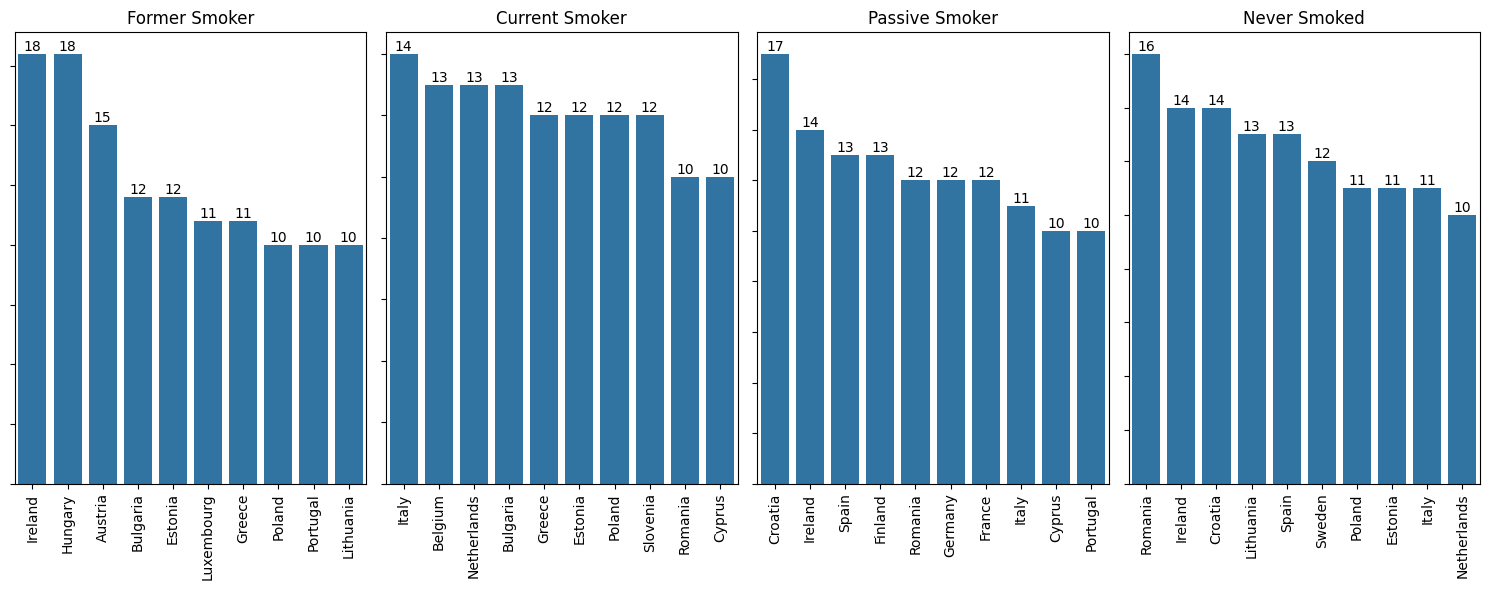

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(15, 6))
for i, j in enumerate(df["smoking_status"].unique()):
    temp_df = df[df["smoking_status"] == j]
    count = pd.DataFrame(temp_df["country"].value_counts()).sort_values("count", ascending=False)
    sns.barplot(x=count.index[:10], y=count.iloc[:10, 0], ax=axes[i])
    for container in axes[i].containers:
        axes[i].bar_label(container)
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=90)
    axes[i].set_yticklabels(())
    axes[i].set_ylabel("")
    axes[i].set_xlabel("")
    axes[i].set_title(j)
plt.tight_layout()
plt.show()

# Count of smoking status and its influence on lung cancer occurence

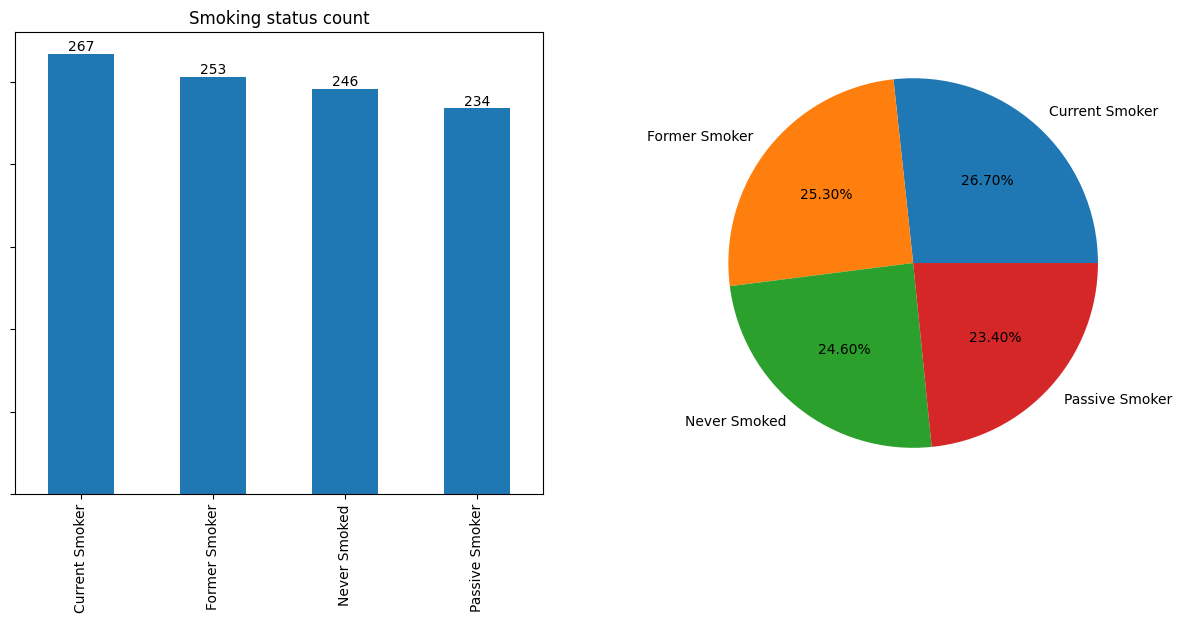

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(15, 6))
df["smoking_status"].value_counts().plot(kind="bar", ax=axes[0])
for container in axes[0].containers:
    axes[0].bar_label(container)
axes[0].set_yticklabels(())
axes[0].set_ylabel("")
axes[0].set_xlabel("")
axes[0].set_title("Smoking status count")
df["smoking_status"].value_counts().plot(kind="pie", ax=axes[1], autopct="%0.2f%%")
axes[1].set_ylabel("")
plt.show()

# Influence of smoking status on cancer survival

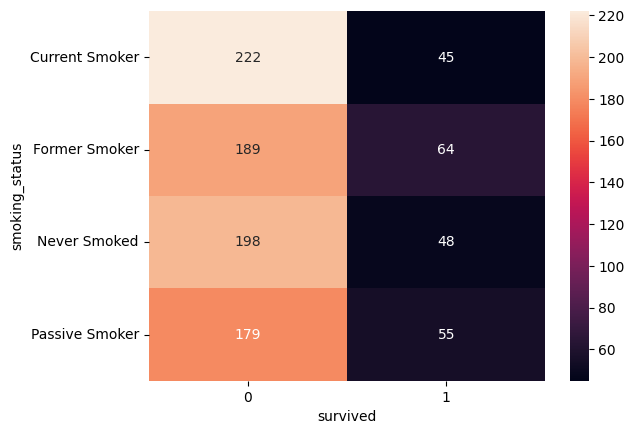

In [ ]:
cross = pd.crosstab(df["smoking_status"], df["survived"])
sns.heatmap(cross, annot=True, fmt='d')
plt.show()

# 10 countries with highest BMI levels and cholesterol levels

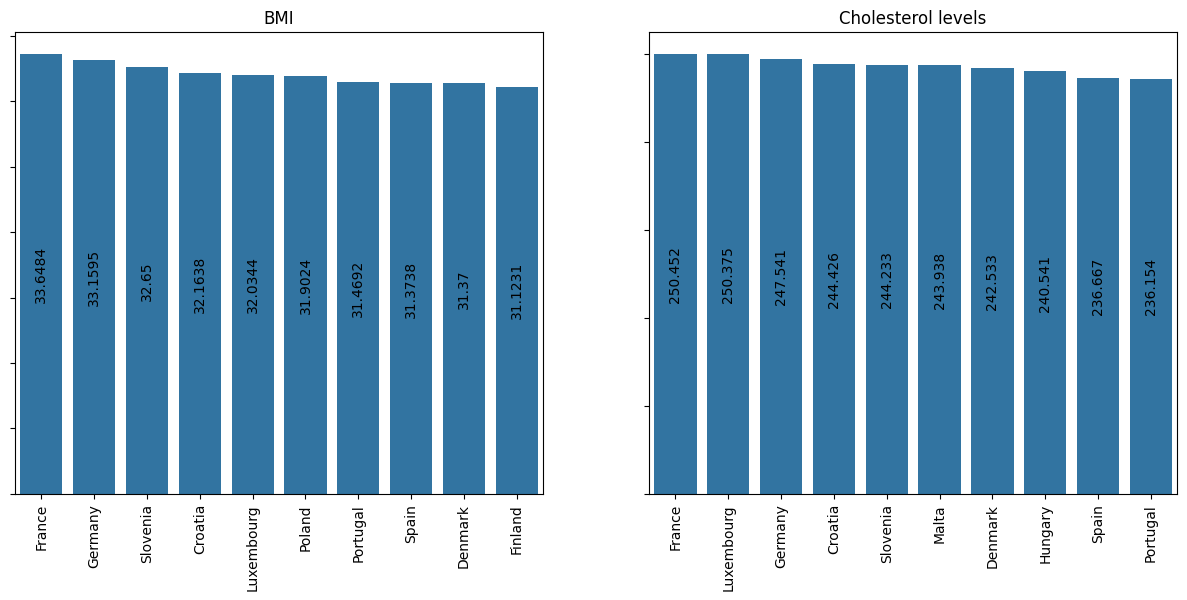

In [ ]:
grouped = df.groupby("country")
bmi = pd.DataFrame(grouped["bmi"].mean()).sort_values("bmi", ascending=False)
chol = pd.DataFrame(grouped["cholesterol_level"].mean()).sort_values("cholesterol_level", ascending=False)
fig, axes = plt.subplots(ncols=2, figsize=(15, 6))
i = 0
sns.barplot(x=bmi.index[:10], y=bmi.iloc[:10, 0], ax=axes[i])
for container in axes[i].containers:
    axes[i].bar_label(container, rotation=90, label_type="center")
axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=90)
axes[i].set_yticklabels(())
axes[i].set_ylabel("")
axes[i].set_xlabel("")
axes[i].set_title("BMI")
i += 1
sns.barplot(x=chol.index[:10], y=chol.iloc[:10, 0], ax=axes[i])
for container in axes[i].containers:
    axes[i].bar_label(container, rotation=90, label_type="center")
axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=90)
axes[i].set_yticklabels(())
axes[i].set_ylabel("")
axes[i].set_xlabel("")
axes[i].set_title("Cholesterol levels")
plt.show()

# Data distribution of BMI and cholesterol levels for cases with lethal and non-lethal outcomes

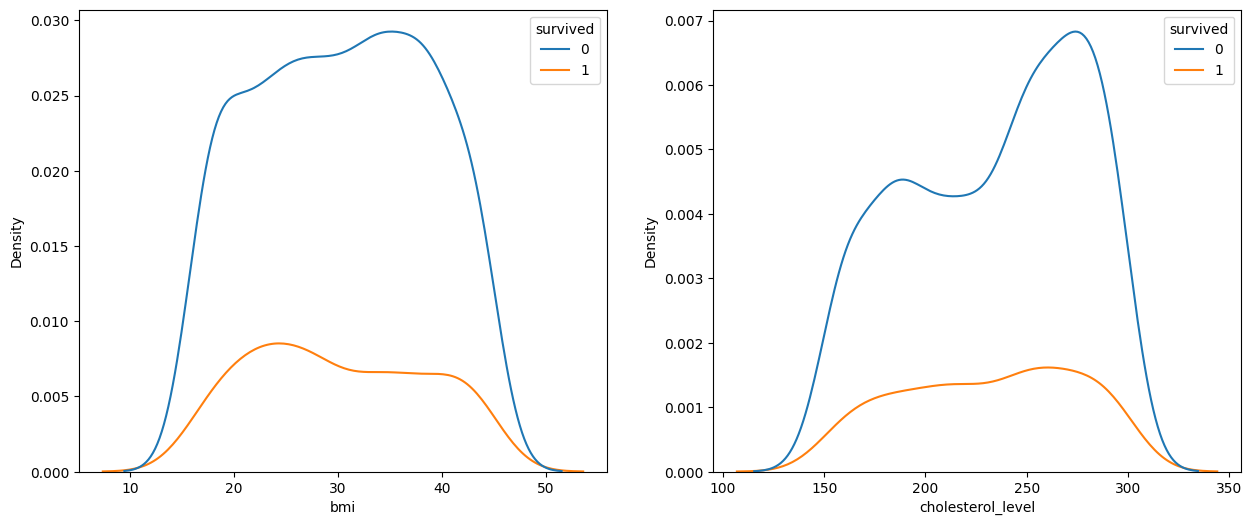

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(15, 6))

sns.kdeplot(df, x="bmi", hue="survived", ax=axes[0])
sns.kdeplot(df, x="cholesterol_level", hue="survived", ax=axes[1])
plt.show()

# Count of gender with lung cancer cases

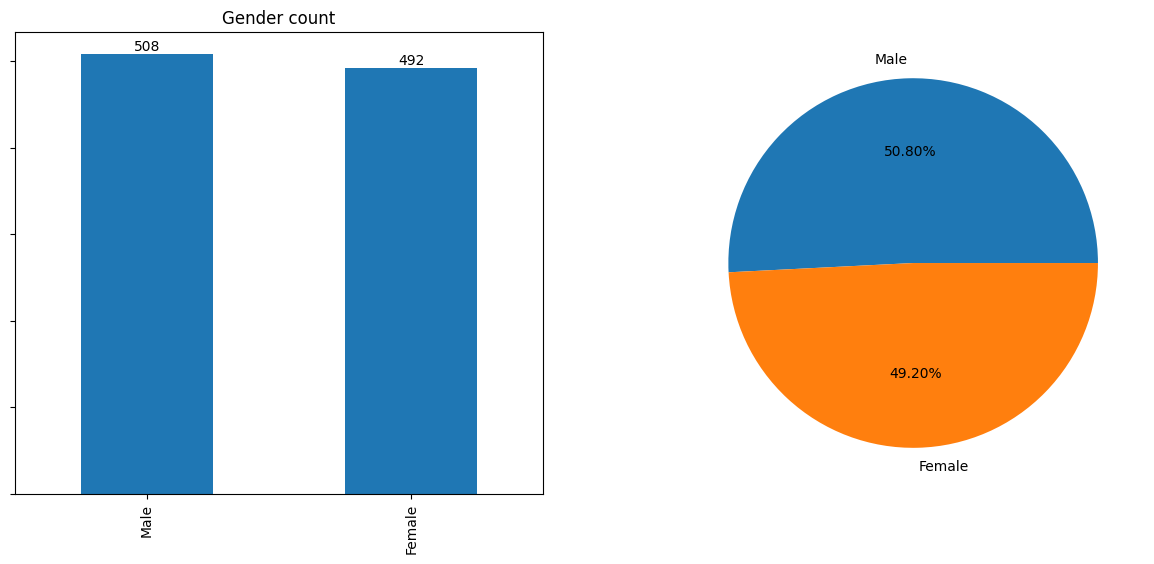

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(15, 6))
df["gender"].value_counts().plot(kind="bar", ax=axes[0])
for container in axes[0].containers:
    axes[0].bar_label(container)
axes[0].set_yticklabels(())
axes[0].set_ylabel("")
axes[0].set_xlabel("")
axes[0].set_title("Gender count")
df["gender"].value_counts().plot(kind="pie", ax=axes[1], autopct="%0.2f%%")
axes[1].set_ylabel("")
plt.show()

# Influence of gender on lung cancer

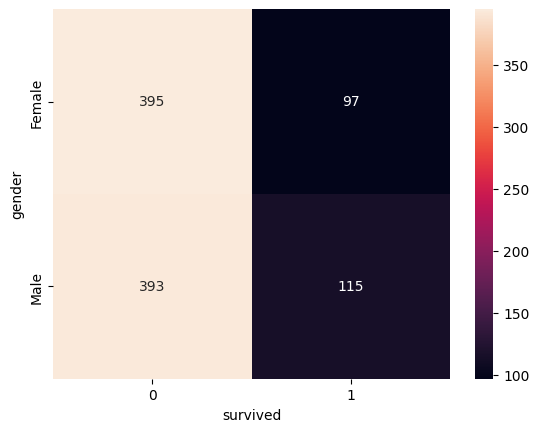

In [ ]:
cross = pd.crosstab(df["gender"], df["survived"])
sns.heatmap(cross, annot=True, fmt='d')
plt.show()

# Average age in both genders to have lung cancer

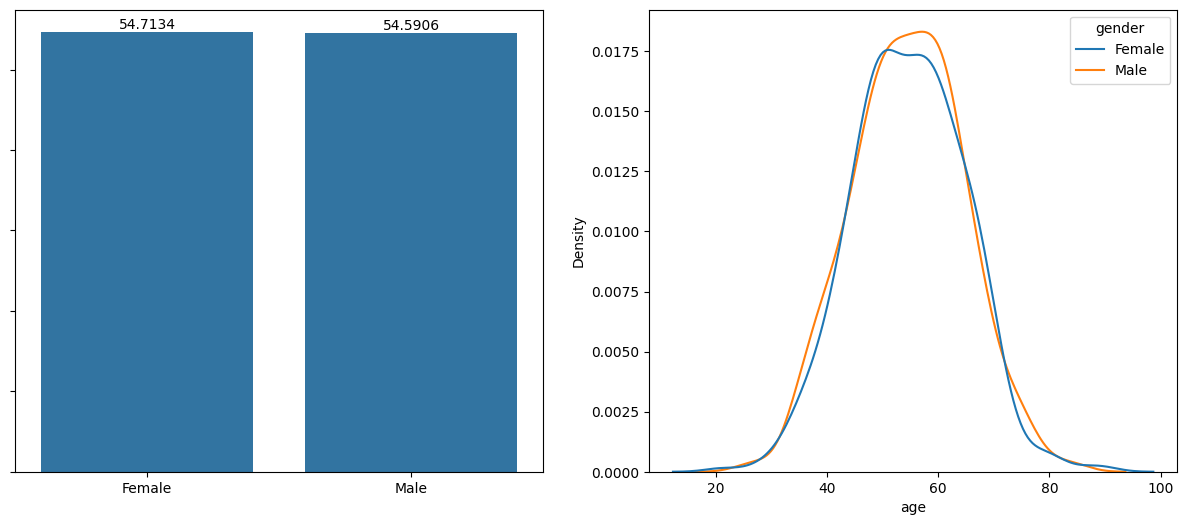

In [ ]:
grouped = df.groupby("gender")
mean = grouped["age"].mean()
fig, axes = plt.subplots(ncols=2, figsize=(15, 6))
sns.barplot(x=mean.index, y=mean, ax=axes[0])
for container in axes[0].containers:
    axes[0].bar_label(container)
axes[0].set_yticklabels(())
axes[0].set_ylabel("")
axes[0].set_xlabel("")

sns.kdeplot(df, x="age", hue="gender", ax=axes[1])

plt.show()

# Which gender has tendencies for various smoking statuses

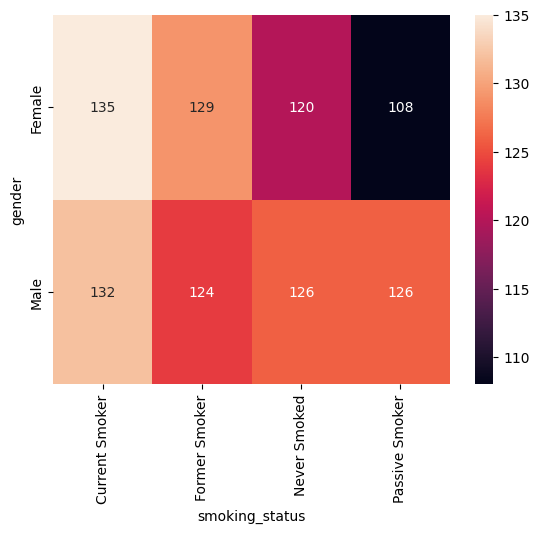

In [ ]:
cross = pd.crosstab(df["gender"], df["smoking_status"])
sns.heatmap(cross, annot=True, fmt='d')
plt.show()

# Influence of other diagnoses on the outcome of treatment

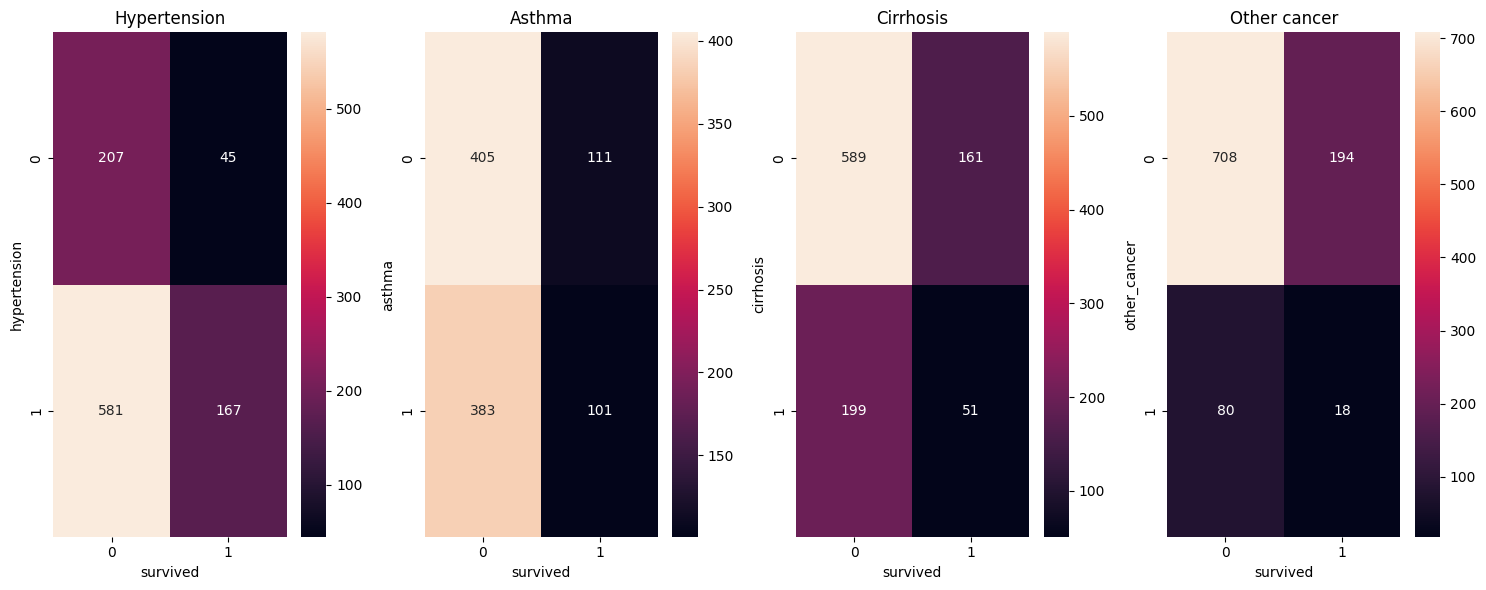

In [ ]:
diseases = ["hypertension", "asthma", "cirrhosis", "other_cancer"]

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(15, 6))
for i, j in enumerate(diseases):
    cross = pd.crosstab(df[j], df["survived"])
    sns.heatmap(cross, annot=True, fmt='d', ax=axes[i])
    axes[i].set_title(j.replace('_', ' ').capitalize())
plt.tight_layout()
plt.show()

# Treatment approaches tendencies

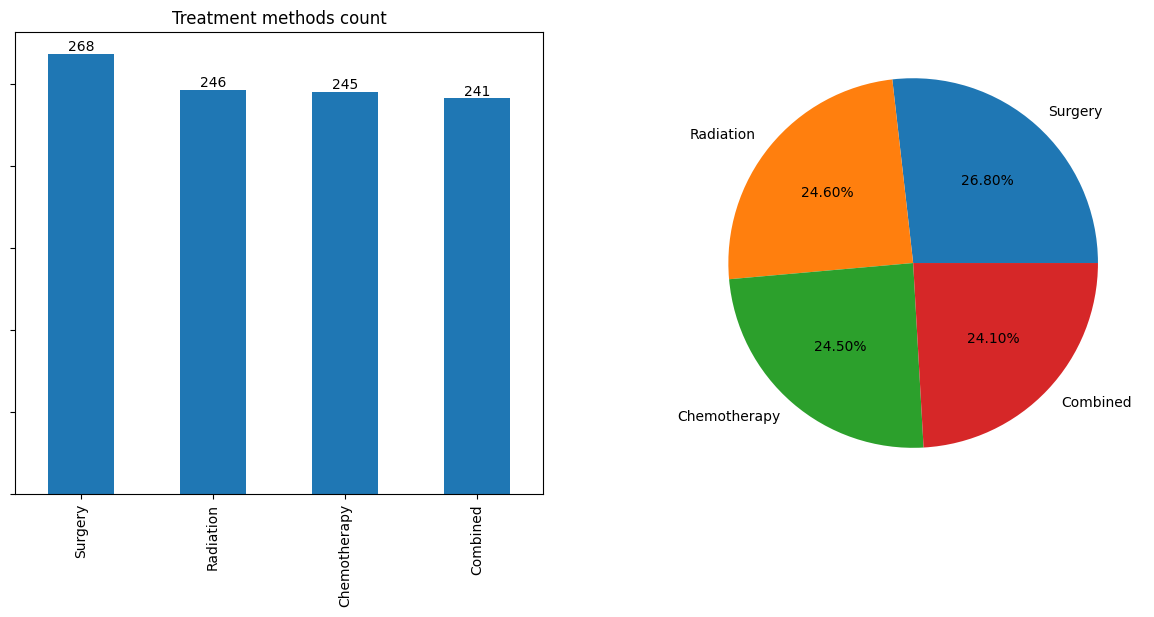

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(15, 6))
df["treatment_type"].value_counts().plot(kind="bar", ax=axes[0])
for container in axes[0].containers:
    axes[0].bar_label(container)
axes[0].set_yticklabels(())
axes[0].set_ylabel("")
axes[0].set_xlabel("")
axes[0].set_title("Treatment methods count")
df["treatment_type"].value_counts().plot(kind="pie", ax=axes[1], autopct="%0.2f%%")
axes[1].set_ylabel("")
plt.show()

# Influence of treatment type on the outcome

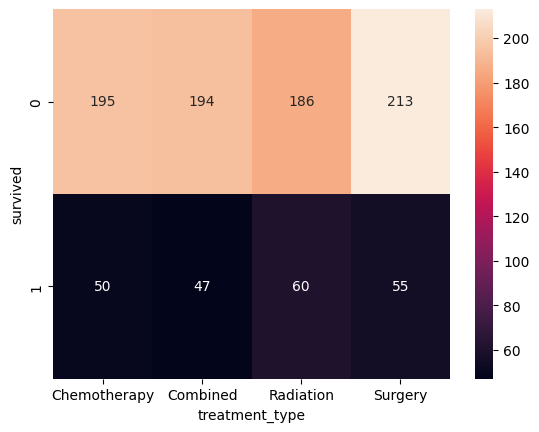

In [ ]:
cross = pd.crosstab(df["survived"], df["treatment_type"])
sns.heatmap(cross, annot=True, fmt='d')
plt.show()

# Cases of lung cancer in family history influence on lung cancer occurence

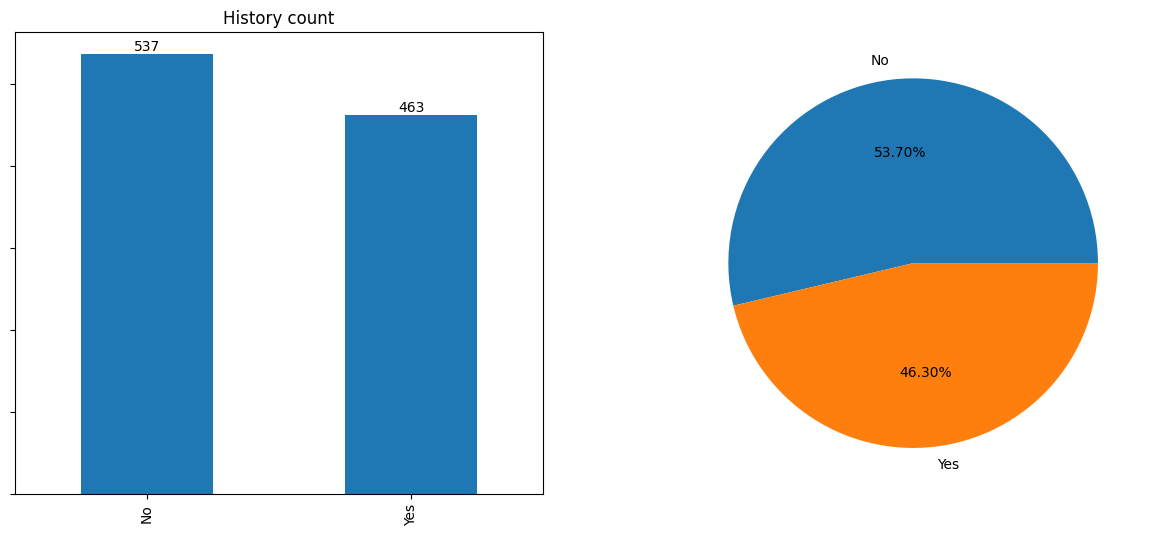

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(15, 6))
df["family_history"].value_counts().plot(kind="bar", ax=axes[0])
for container in axes[0].containers:
    axes[0].bar_label(container)
axes[0].set_yticklabels(())
axes[0].set_ylabel("")
axes[0].set_xlabel("")
axes[0].set_title("History count")
df["family_history"].value_counts().plot(kind="pie", ax=axes[1], autopct="%0.2f%%")
axes[1].set_ylabel("")
plt.show()

# Influence of family history on survival

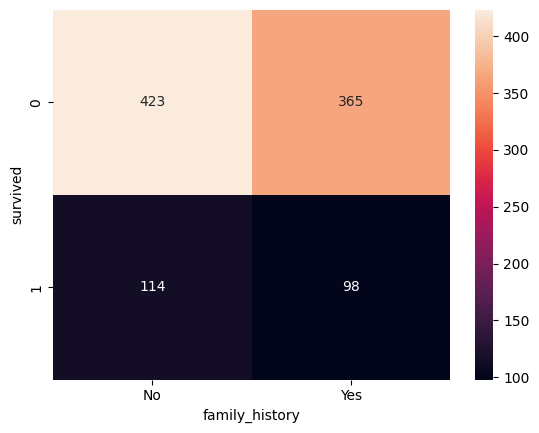

In [ ]:
cross = pd.crosstab(df["survived"], df["family_history"])
sns.heatmap(cross, annot=True, fmt='d')
plt.show()

# Encoding categorical variables

In [ ]:
categoricals = ["gender", "country", "cancer_stage", "family_history", "smoking_status", "treatment_type"]

le = LabelEncoder()
for i in categoricals:
    df[i] = le.fit_transform(df[i].values)

# Selecting features for training

In [ ]:
x = df.drop(["id", "diagnosis_date", "end_treatment_date", "survived", "beginning_of_treatment_date"], axis=1).values
y = df.loc[:, "survived"].values

# Scaling values

In [ ]:
scaler = MinMaxScaler()

x = scaler.fit_transform(x)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42, test_size=0.2)

# Applying SMOTE to deal with class imbalance

In [ ]:
smote = SMOTE()
print("Before: ", Counter(y_train))
x_train, y_train = smote.fit_resample(x_train, y_train)
print("After: ", Counter(y_train))

Before:  Counter({0: 630, 1: 170})
After:  Counter({0: 630, 1: 630})


In [ ]:
def training(model):
    model.fit(x_train, y_train)
    pred = model.predict(x_test)
    proba = model.predict_proba(x_test)
    score = accuracy_score(pred, y_test)
    report = classification_report(pred, y_test)
    cm = confusion_matrix(pred, y_test)

    return score*100, report, cm, pred, proba

# Classic ML models

In [ ]:
rfc = RandomForestClassifier()
etc = ExtraTreesClassifier()
gbc = GradientBoostingClassifier()
abc = AdaBoostClassifier()
xgb = XGBClassifier()
lgb = LGBMClassifier()
lgr = LogisticRegression()

models = [rfc, etc, gbc,
         abc, xgb, lgb, lgr]

names = ["Random Forest", "Extra Trees", "Gradient Boosting",
        "Ada Boost", "XGB", "LGB", "Logistic Regression"]

# ANN model for classification

In [ ]:
in_features = tf.keras.Input(shape=(x.shape[1], ))
layer1 = tf.keras.layers.Dense(32, activation="relu")(in_features)
droput = tf.keras.layers.Dropout(0.2)(layer1)
layer = tf.keras.layers.Dense(2, activation="softmax")(droput)
model = tf.keras.Model(inputs=in_features, outputs=layer)
model.compile(optimizer=tf.keras.optimizers.Adam(),
             loss="categorical_crossentropy",
             metrics=["accuracy"])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 15)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │              66 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 578 (2.26 KB)

 Trainable params: 578 (2.26 KB)

 Non-trainable params: 0 (0.00 B)

# Training ML models and saving their evaluation performance

In [ ]:
scores, reports, cms, preds, probas = [], dict(), dict(), dict(), dict()

for i, j in zip(models, names):
    score, report, cm, pred, proba = training(i)
    scores += [score]
    reports[j] = report
    cms[j] = cm
    preds[j] = pred
    probas[j] = proba

[LightGBM] [Info] Number of positive: 630, number of negative: 630
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000628 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2367
[LightGBM] [Info] Number of data points in the train set: 1260, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


In [ ]:
y_cat = tf.keras.utils.to_categorical(y_train)

# Training ANN model

In [ ]:
history = model.fit(x_train, y_cat, batch_size=8, epochs=20, validation_split=0.1)

Epoch 1/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5175 - loss: 0.7079 - val_accuracy: 0.0873 - val_loss: 0.8540
Epoch 2/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5605 - loss: 0.6828 - val_accuracy: 0.0873 - val_loss: 0.8477
Epoch 3/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5514 - loss: 0.6709 - val_accuracy: 0.1667 - val_loss: 0.8198
Epoch 4/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5860 - loss: 0.6718 - val_accuracy: 0.2778 - val_loss: 0.8008
Epoch 5/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6065 - loss: 0.6629 - val_accuracy: 0.5714 - val_loss: 0.7062
Epoch 6/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5748 - loss: 0.6591 - val_accuracy: 0.4762 - val_loss: 0.7366
Epoch 7/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6221 - loss: 0.6608 - val_accuracy: 0.3968 - val_loss: 0.7655
Epoch 8/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6169 - loss: 0.6430 - val_accuracy: 0.

# Performance log

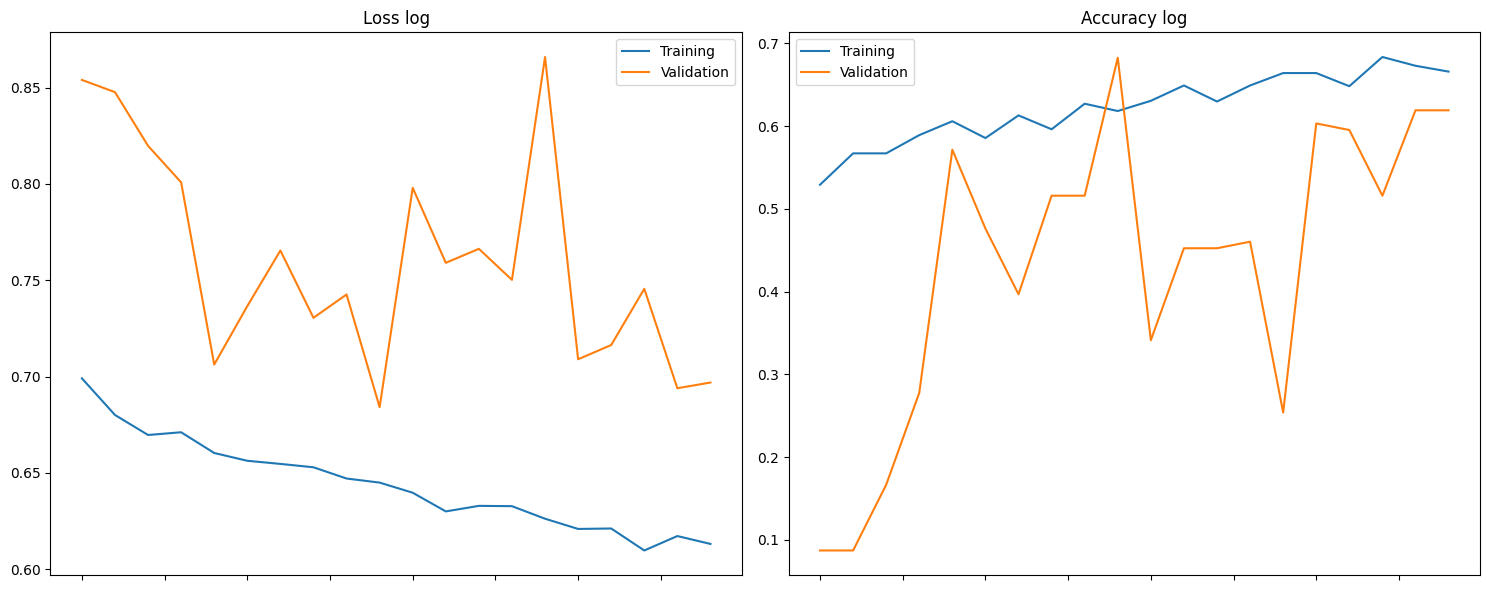

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(15, 6))

index = 0
axes[index].plot(history.history["loss"], label="Training")
axes[index].plot(history.history["val_loss"], label="Validation")
axes[index].legend()
axes[index].set_xlabel("")
axes[index].set_ylabel("")
axes[index].set_xticklabels(())
axes[index].set_title("Loss log")
index += 1

axes[index].plot(history.history["accuracy"], label="Training")
axes[index].plot(history.history["val_accuracy"], label="Validation")
axes[index].legend()
axes[index].set_xlabel("")
axes[index].set_ylabel("")
axes[index].set_xticklabels(())
axes[index].set_title("Accuracy log")

plt.tight_layout()
plt.show()

In [ ]:
proba = model.predict(x_test)
pred = [np.argmax(i) for i in proba]
score = accuracy_score(pred, y_test)
report = classification_report(pred, y_test)
cm = confusion_matrix(pred, y_test)

scores += [score*100]
reports["ANN"] = report
cms["ANN"] = cm
preds["ANN"] = pred
probas["ANN"] = proba

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


In [ ]:
names += ["ANN"]

# Models evaluation score rated

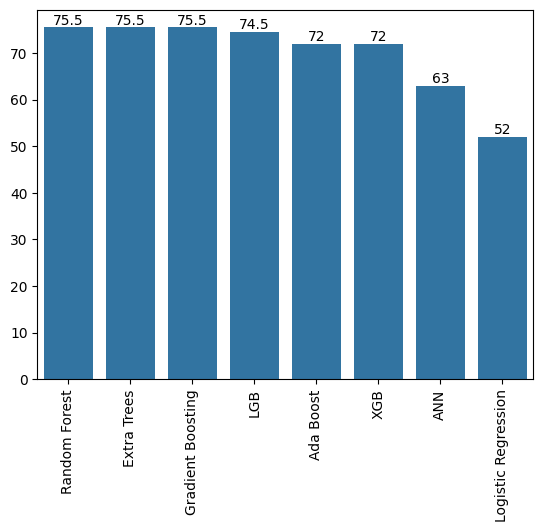

In [ ]:
dd = pd.DataFrame({"scores": scores}, index=names).sort_values("scores", ascending=False)
dd["scores"] = round(dd["scores"], 2)
fig, axes = plt.subplots()
sns.barplot(x=dd.index, y=dd.iloc[:, 0], ax=axes)
for container in axes.containers:
    axes.bar_label(container)
axes.set_xticklabels(axes.get_xticklabels(), rotation=90)
axes.get_yticklabels(())
axes.set_xlabel("")
axes.set_ylabel("")

plt.show()

# Different version for model to predict survival or lethal outcome probability

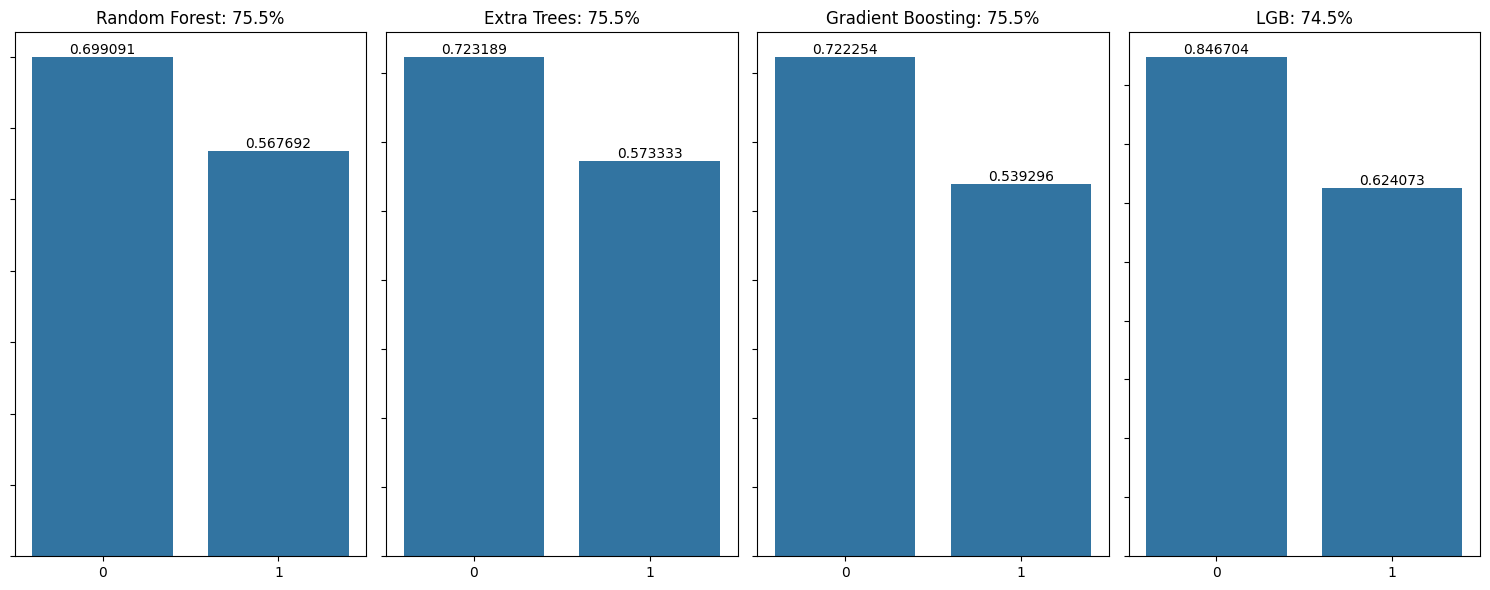

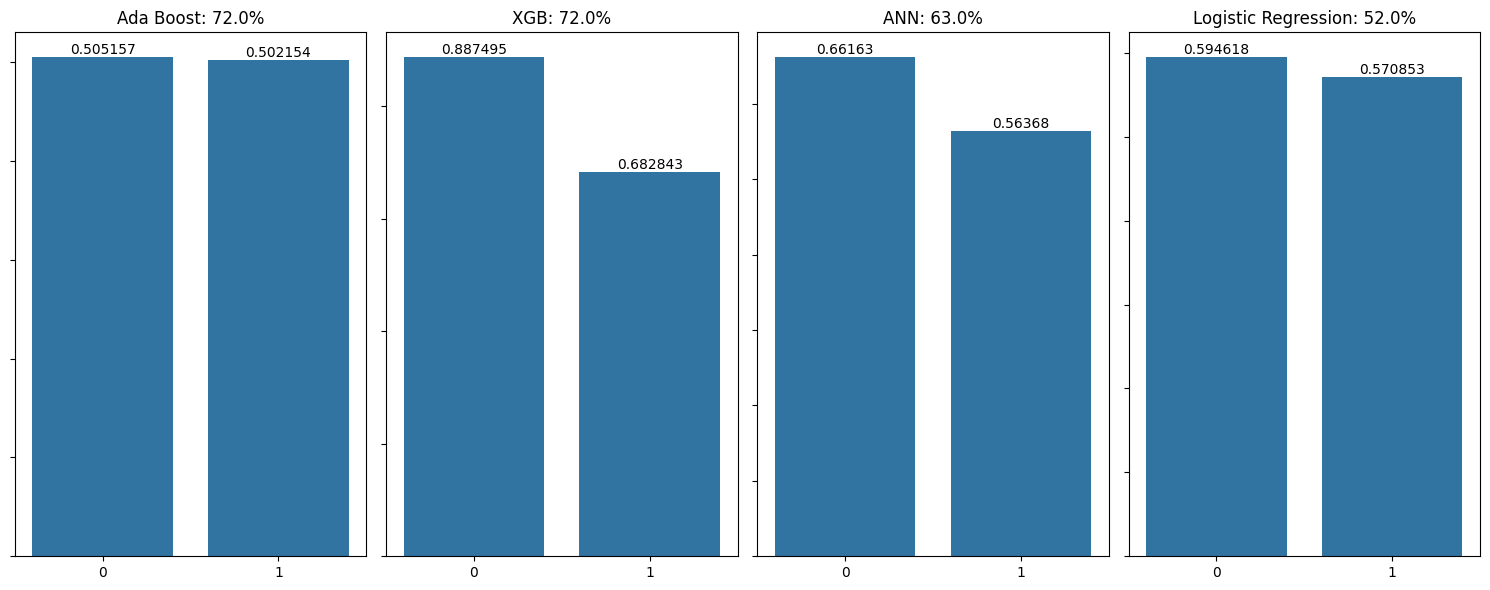

In [ ]:
index = 0
for i in range(2):
    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(15, 6))
    for j in range(4):
        dt = {"labels": [], "probabilities": []}
        for k, l in zip(preds[dd.index[index]], probas[dd.index[index]]):
            dt["labels"] += [k]
            dt["probabilities"] += [l[k]]
        dt = pd.DataFrame(dt)
        grouped = dt.groupby("labels")
        mean = grouped["probabilities"].mean()
        sns.barplot(x=mean.index, y=mean, ax=axes[j])
        for container in axes[j].containers:
            axes[j].bar_label(container)
        axes[j].set_ylabel("")
        axes[j].set_xlabel("")
        axes[j].set_yticklabels(())
        axes[j].set_title("{}: {}%".format(dd.index[index], dd.iloc[index, 0]))
        index += 1
    plt.tight_layout()
    plt.show()

# Confusion matrices

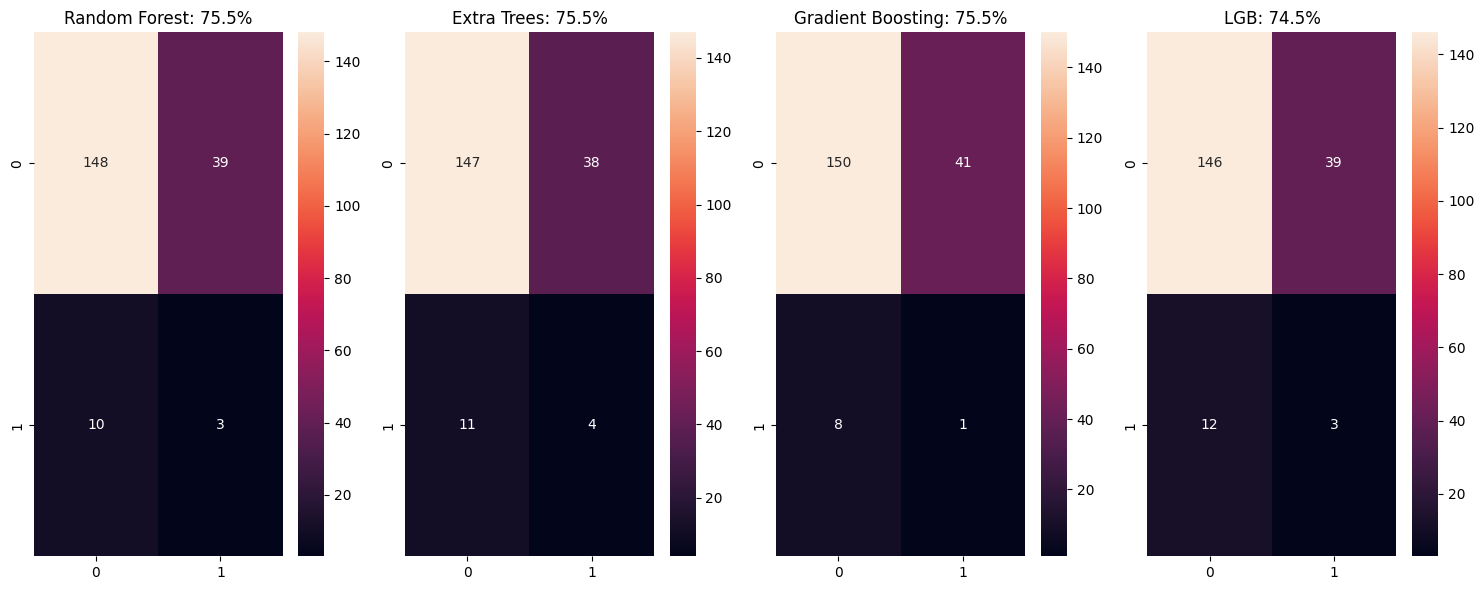

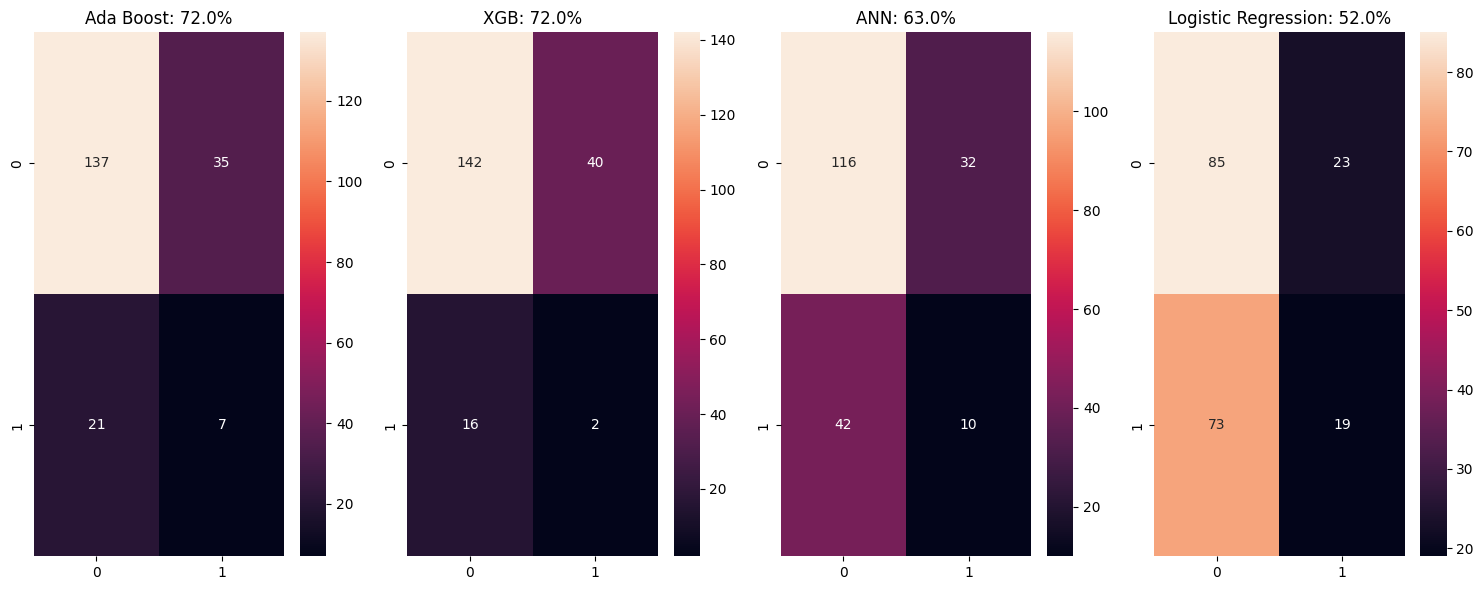

In [ ]:
index = 0
for i in range(2):
    fig, axes = plt.subplots(ncols=4, figsize=(15, 6))
    for j in range(4):
        sns.heatmap(cms[dd.index[index]], annot=True, fmt='d', ax=axes[j])
        axes[j].set_title("{}: {}%".format(dd.index[index], dd.iloc[index, 0]))
        index += 1
    plt.tight_layout()
    plt.show()

# Classification reports

In [ ]:
for i in dd.index:
    print(i)
    print(reports[i])
    print("\n\n")

Random Forest
              precision    recall  f1-score   support

           0       0.94      0.79      0.86       187
           1       0.07      0.23      0.11        13

    accuracy                           0.76       200
   macro avg       0.50      0.51      0.48       200
weighted avg       0.88      0.76      0.81       200




Extra Trees
              precision    recall  f1-score   support

           0       0.93      0.79      0.86       185
           1       0.10      0.27      0.14        15

    accuracy                           0.76       200
   macro avg       0.51      0.53      0.50       200
weighted avg       0.87      0.76      0.80       200




Gradient Boosting
              precision    recall  f1-score   support

           0       0.95      0.79      0.86       191
           1       0.02      0.11      0.04         9

    accuracy                           0.76       200
   macro avg       0.49      0.45      0.45       200
weighted avg       0.91 